In [1]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import time
import pandas as pd

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.quantum_info import Statevector
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
import qiskit

In [5]:
# graph generation

def draw_graph(G, colors, pos):
    plt.figure(dpi = 300)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def graph_generation(dim):
    # Generating the system
    N = dim
    G1 = nx.grid_2d_graph(N,N)
    pos = dict( (n, n) for n in G1.nodes() )
    labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )
    # Transform to weighted graph:
    n = N**2
    V = np.arange(0, N, 1)

    E =[]

    tuples = []
    other_tup = []
    point_edge_map = []
    other_map = []
    relations = []

    for edge in G1.edges:
        point1 = edge[0]
        strpoint1 = str(point1[0]) + str(point1[1])
        point2 = edge[1]
        strpoint2 = str(point2[0]) + str(point2[1])
        if not strpoint1 in point_edge_map:
            point_edge_map.append(strpoint1)
            tuples.append(edge[0])
        if not strpoint2 in other_map:
            other_map.append(strpoint2)
            other_tup.append(edge[1])
        relations.append((strpoint1, strpoint2))

    # add periodic boundary conditions
    '''
    grid = np.zeros((dim, dim)).astype('int64').tolist()
    for i in range(dim):
        for j in range(dim):
            pt = str(i) + str(j)
            grid[i][j] = pt
    for i in range(len(grid)):
        relations.append((grid[0][i], grid[dim-1][i]))
        relations.append((grid[i][0], grid[i][dim-1])) 
    '''       
    
    
    tuples.append(other_tup[len(other_tup) - 1])
    point_edge_map.append(other_map[len(other_map) - 1])

    dic = {}
    for i in range(len(point_edge_map)):
        dic[i] = point_edge_map[i]

    point_edge_map = np.array(point_edge_map)
    relations = np.array(relations)

    print(relations)
    for relation in relations:
        ver1 = relation[0]
        ver2 = relation[1]
        point1 = np.where(point_edge_map == ver1)[0][0]
        point2 = np.where(point_edge_map == ver2)[0][0]
        edge = (point1, point2, 1.0)
        E.append(edge)

    G = nx.Graph()

    G.add_nodes_from(V)

    G.add_weighted_edges_from(E)

    colors = ["b" for node in G.nodes()]
    pos = dict()
    for i in range(n):
        pos[i] = tuples[i]


    draw_graph(G, colors, pos)
    
    # Matrix Representation of Graph
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
                
    return G, w, pos

[['00' '10']
 ['00' '01']
 ['01' '11']
 ['01' '02']
 ['02' '12']
 ['02' '03']
 ['03' '13']
 ['03' '04']
 ['04' '14']
 ['10' '20']
 ['10' '11']
 ['11' '21']
 ['11' '12']
 ['12' '22']
 ['12' '13']
 ['13' '23']
 ['13' '14']
 ['14' '24']
 ['20' '30']
 ['20' '21']
 ['21' '31']
 ['21' '22']
 ['22' '32']
 ['22' '23']
 ['23' '33']
 ['23' '24']
 ['24' '34']
 ['30' '40']
 ['30' '31']
 ['31' '41']
 ['31' '32']
 ['32' '42']
 ['32' '33']
 ['33' '43']
 ['33' '34']
 ['34' '44']
 ['40' '41']
 ['41' '42']
 ['42' '43']
 ['43' '44']]


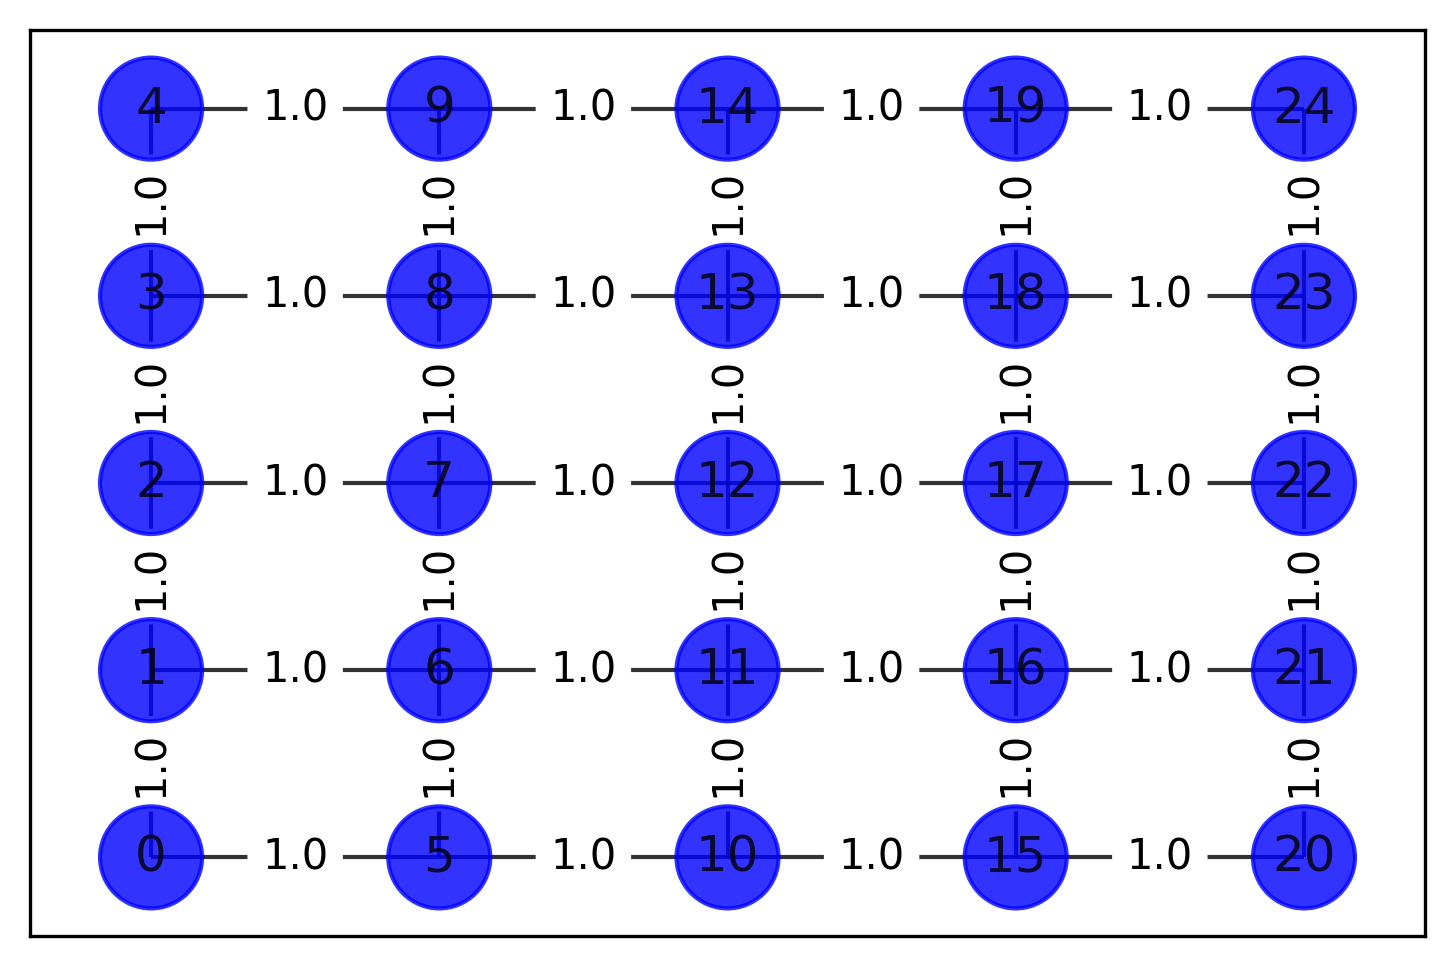

In [8]:
G, w, pos = graph_generation(5)
def graph_convert(sol):
    solution_string = ''
    for i in sol:
        if i=='0' or i=='1':
            solution_string += i
    colors = ["r" if solution_string[i] == '0' else "c" for i in range(25)]
    draw_graph(G, colors, pos)

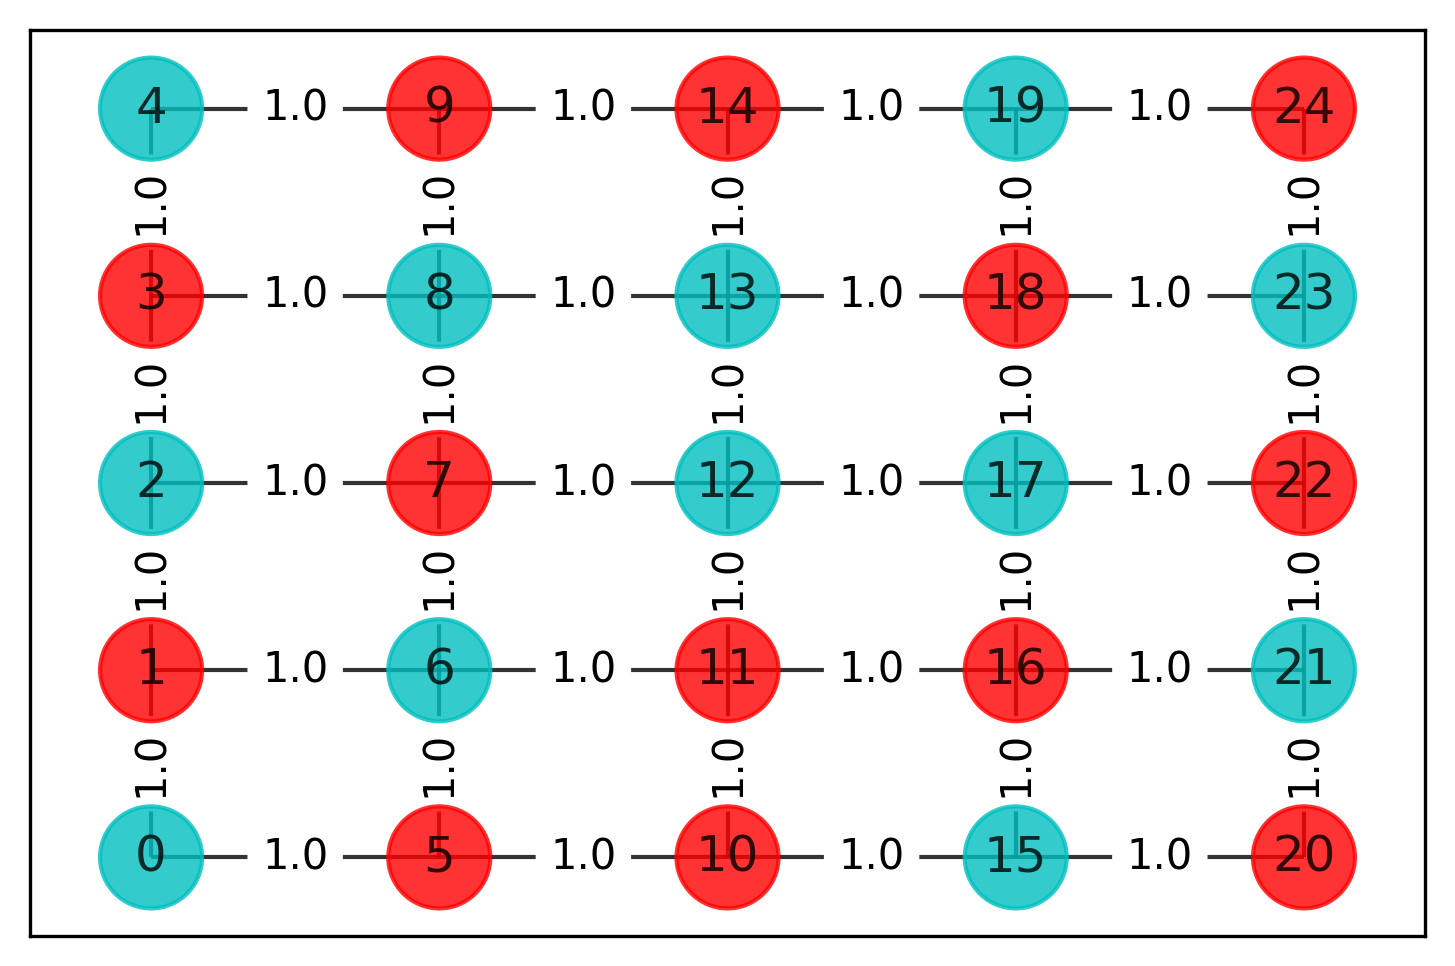

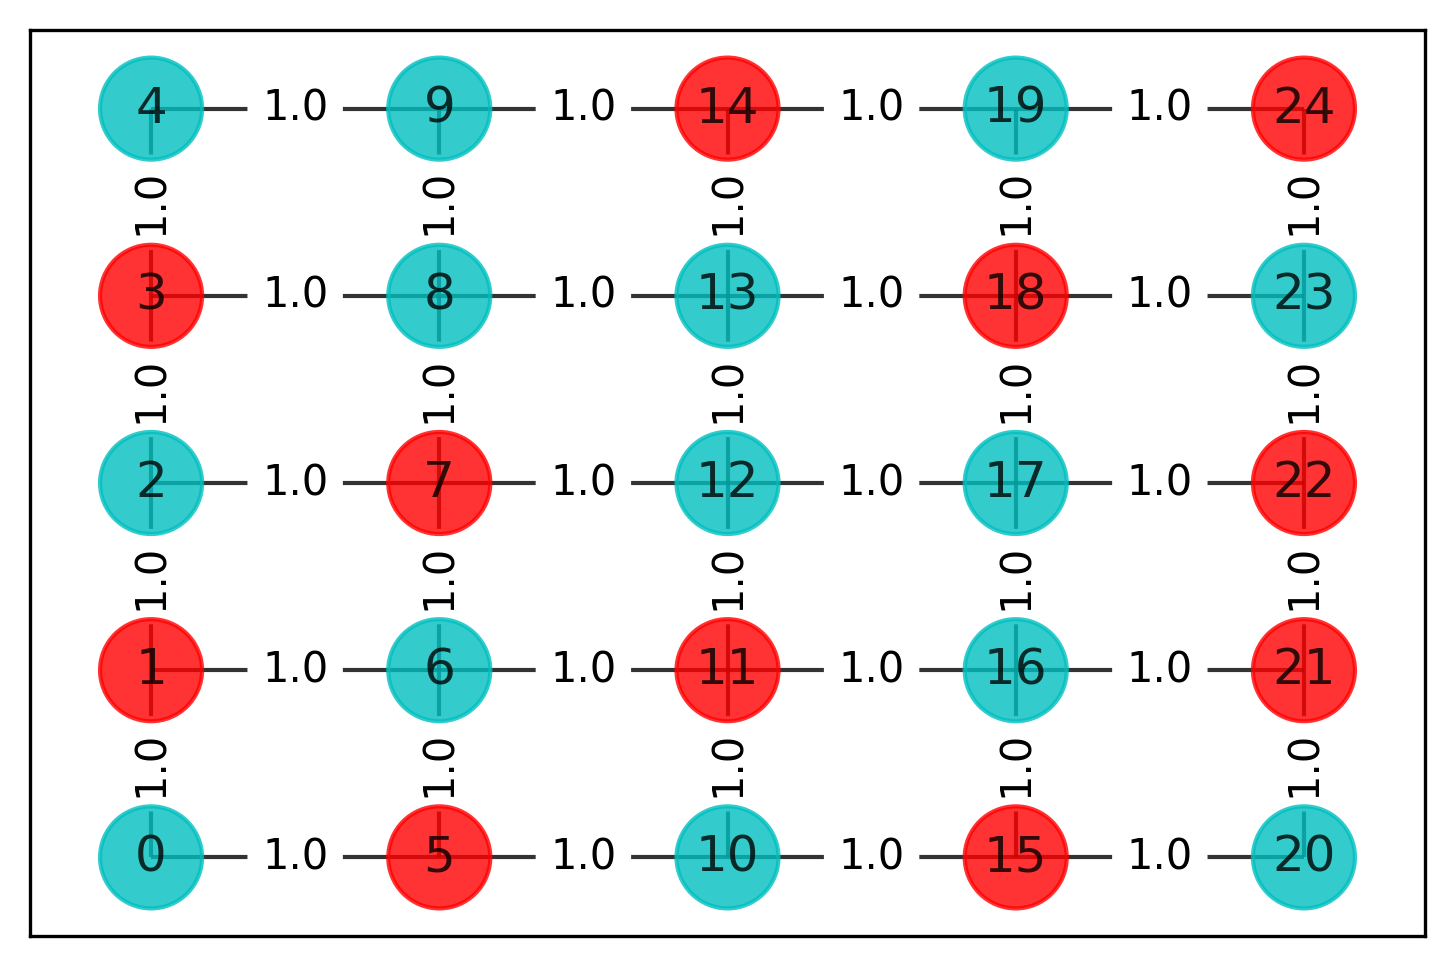

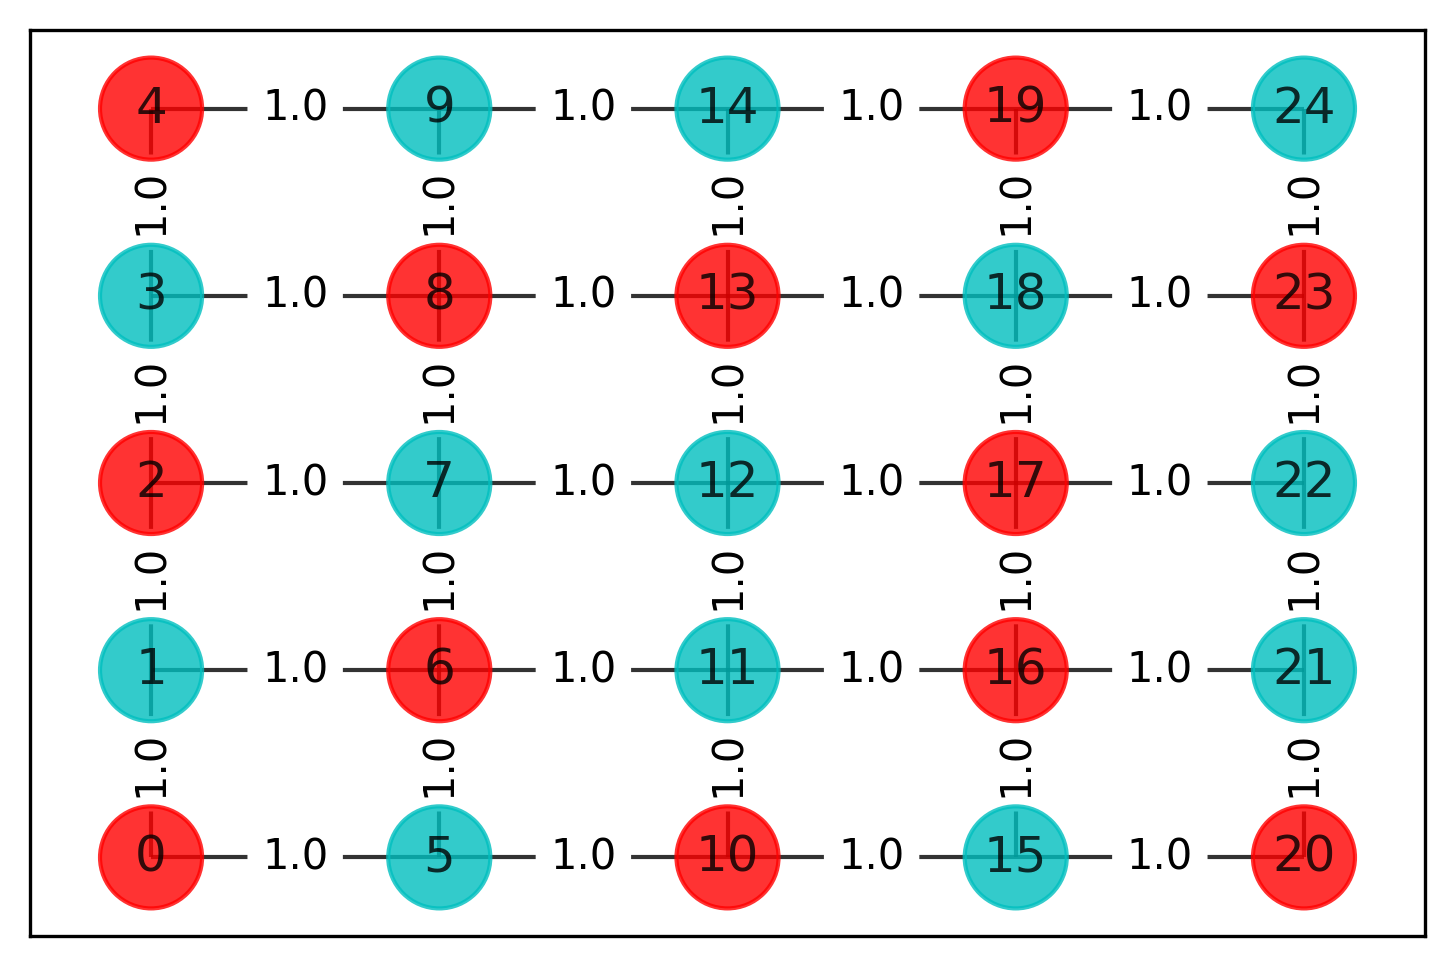

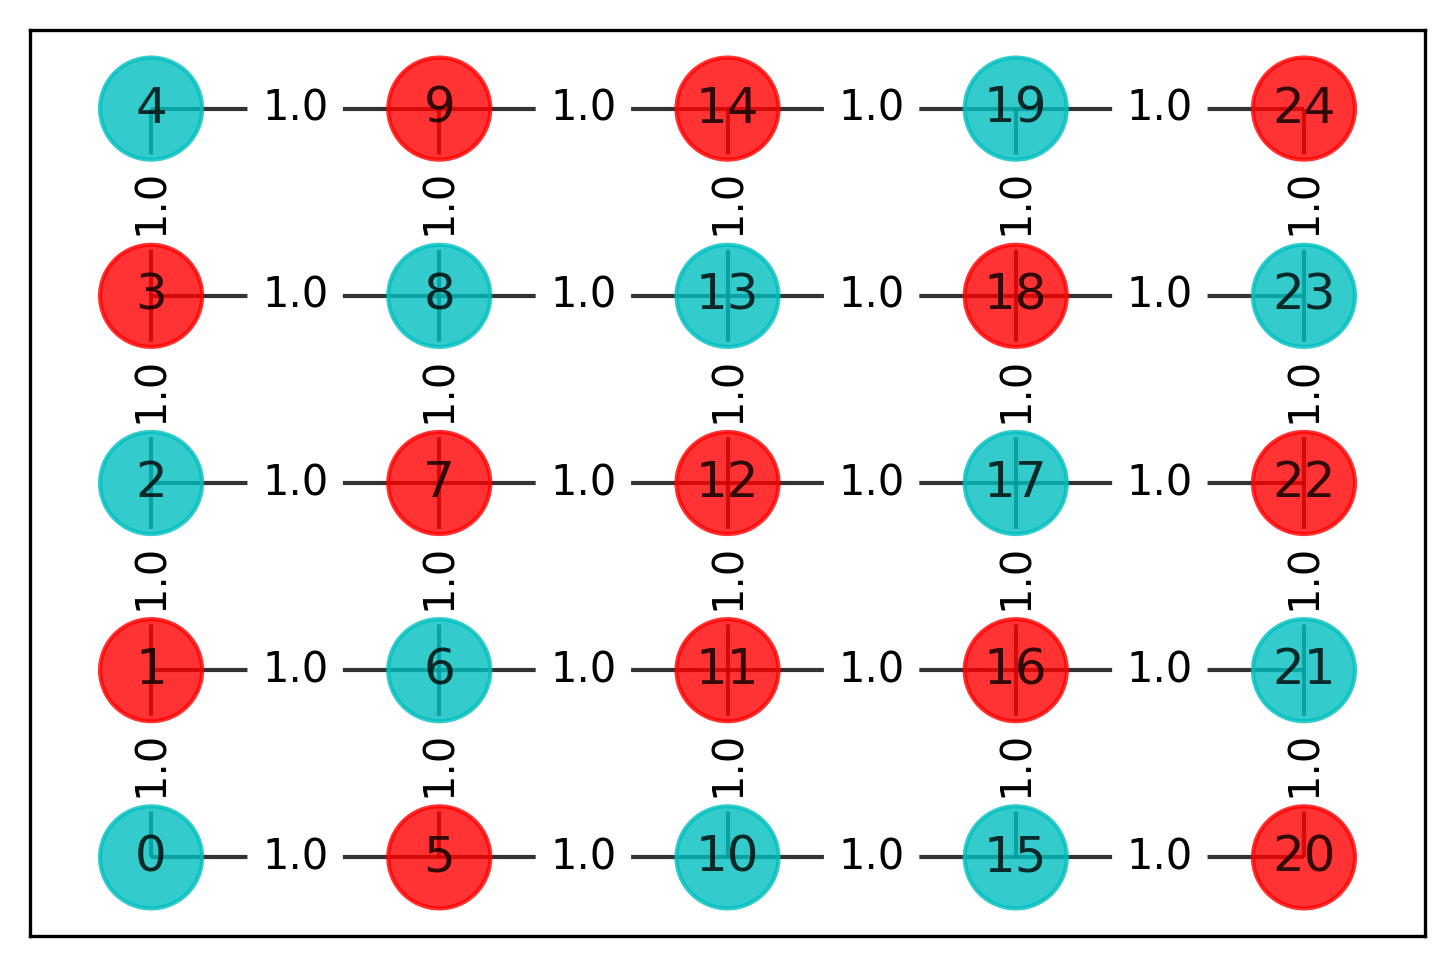

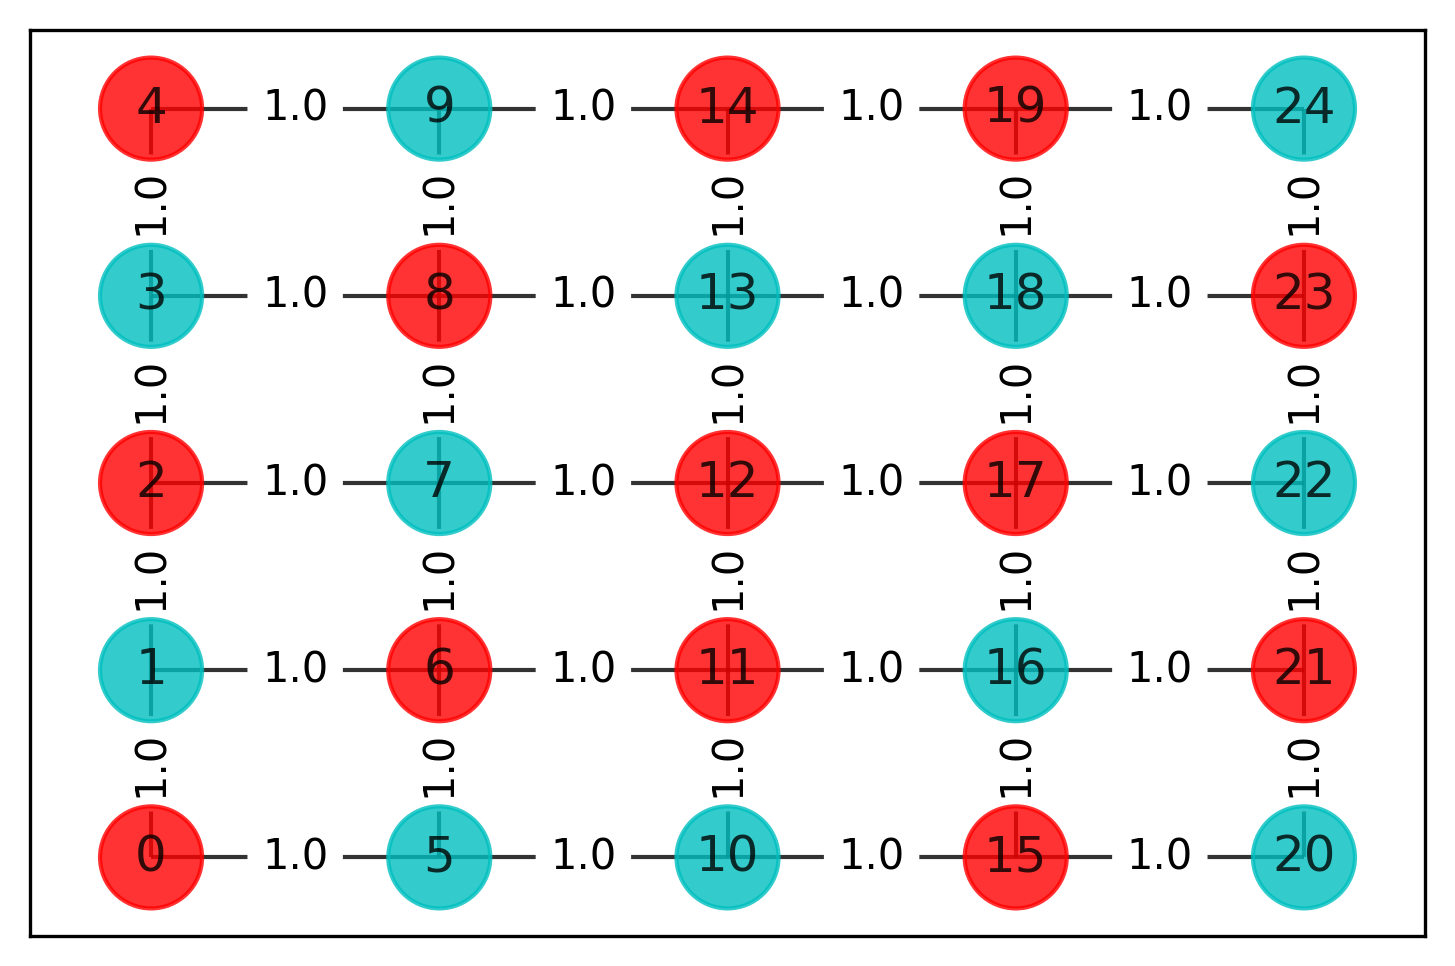

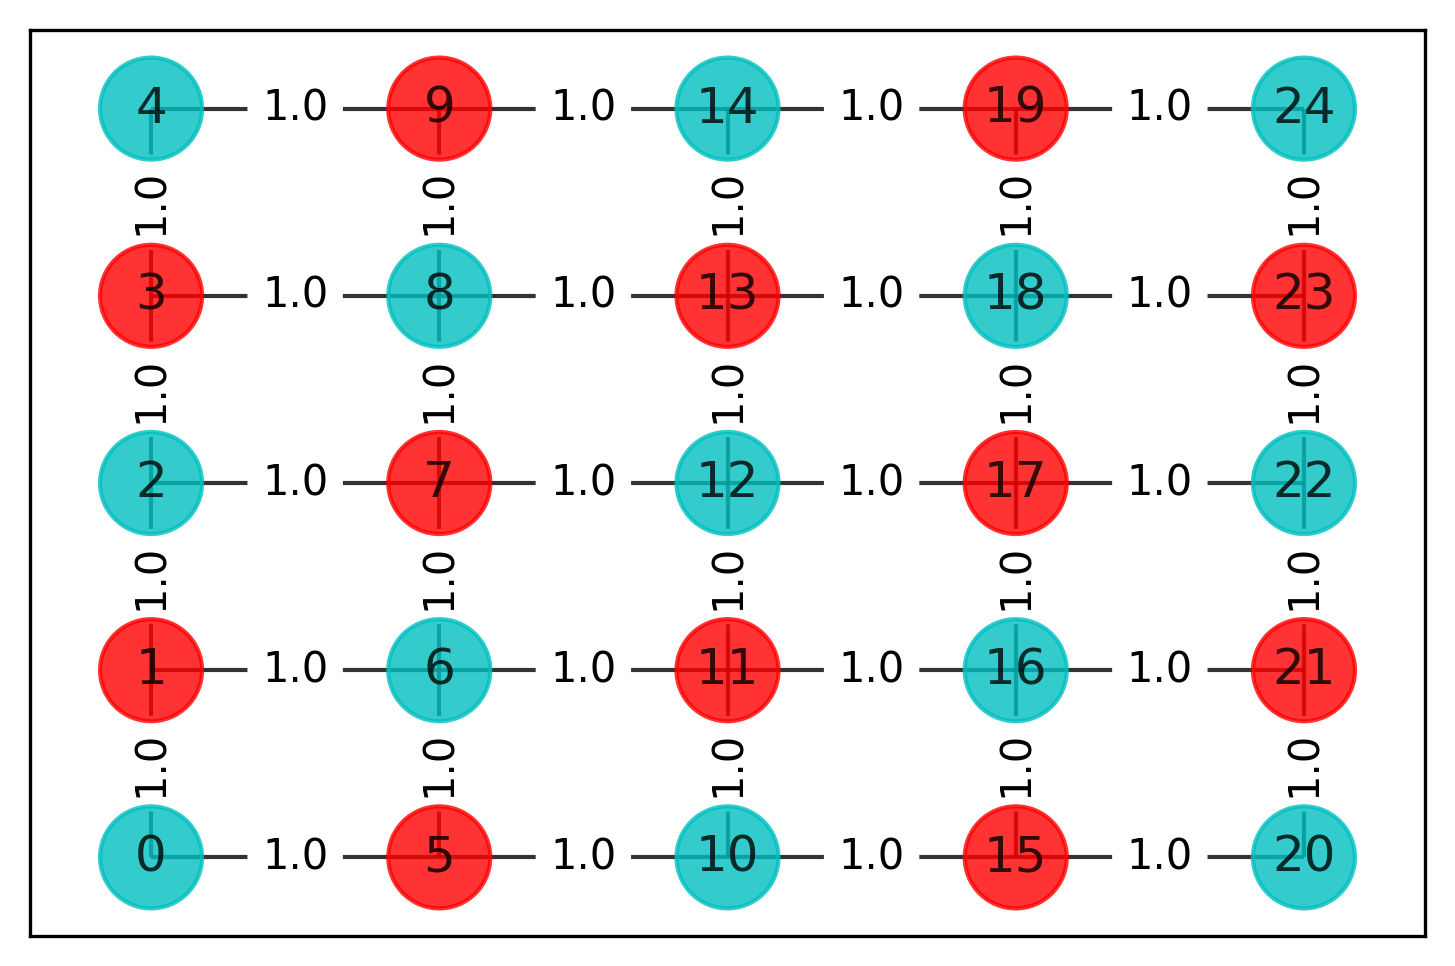

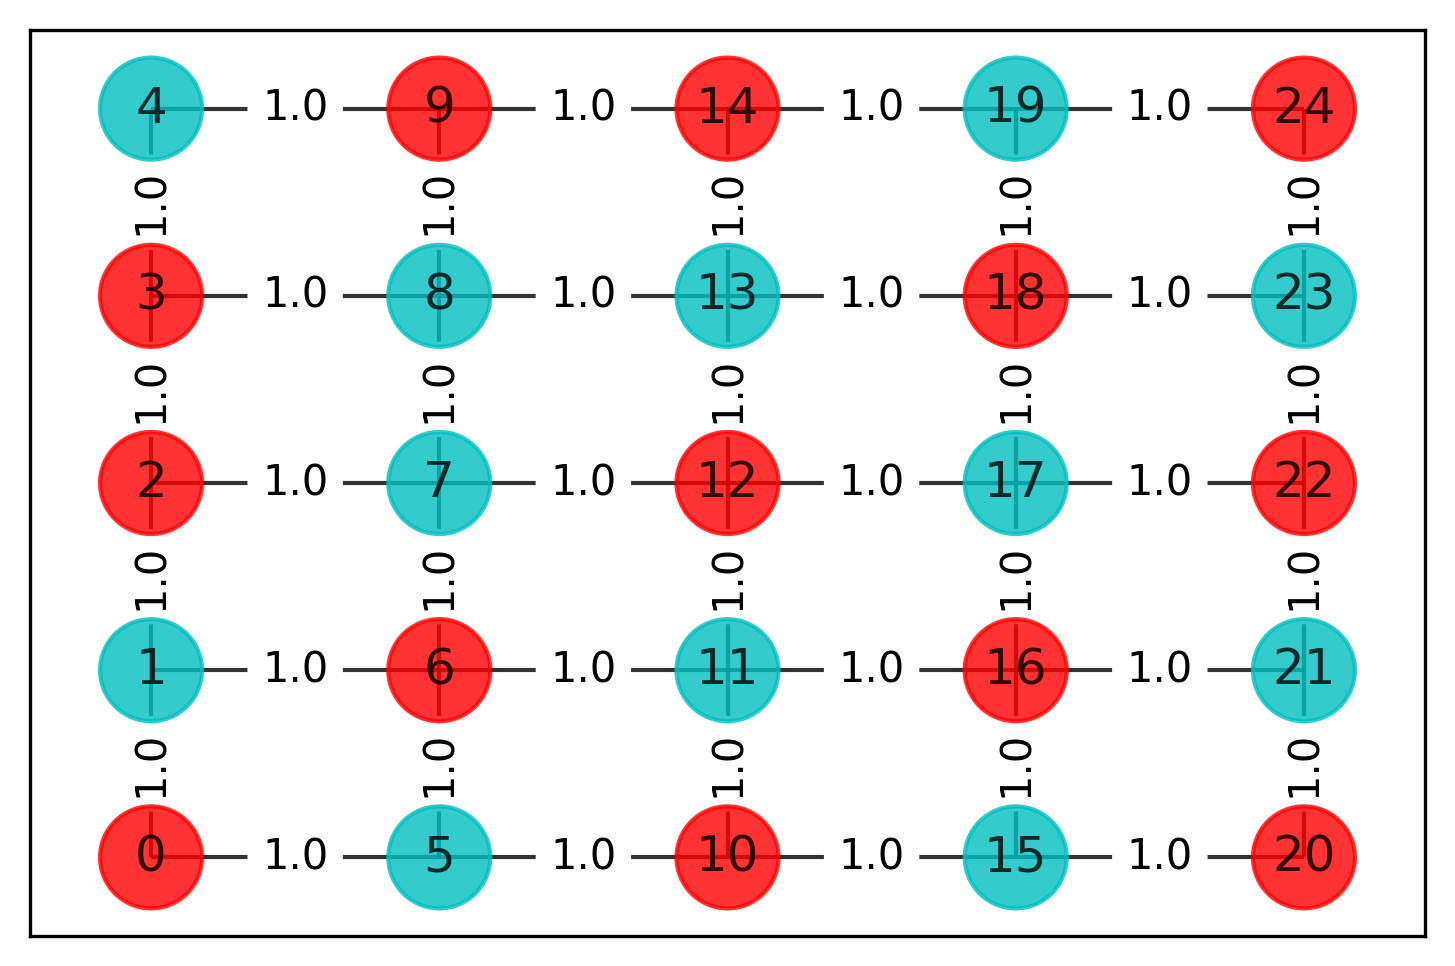

In [10]:
df = pd.read_excel('5x5.xlsx')
sols = df['solution']
for i in range(len(sols)):
    graph_convert(sols[i])
    plt.savefig("5x5 "+str(i)+'.png')